# Analysis Of Customer Data using KMeans Clustering

-----

This workbook goes through the process of analysis of real world data from ..., perfroming : 
- Data Cleaning 
- Feature Engineering 
- Applying KMeans Clustering

This will allow us to make gain insights into the client such as: 

1. Recency - When was the last time the client made a purchase 
2. Frequency - How often does the client make a purchase 
3. Monetary Value - Amount of money generated by the client.

------

## What is KMeans Clustering

KMeans clustering is a unsupervised machine learning algorithm that clusters data in K times. Given a raw unclustered dataset, there are steps to KMeans clusterin are as follows:

1. Select the number of clusters you want to identify in your data (e.g. k =  3, means there will be 3 clusters made from your data)
2. Randomly select k distinct points in your data (e.g. 3 random data points selected)
3. Measure the distance from the first point to the three initial clusters 
4. Assing the 1st data point ot the nearest cluster. 
5. Repeat for all data point in the dataset
6. Calculate the mean for each cluster 
7. Repeat the steps  3 - 5 i.e. measuring distance of the data points, but this time the distance is measured from each data point to the mean value of each cluster rather than the randomly assigned data point 
8. This repeats itslef until the clusters don't change 
9. The best clustering is the one with the least variance, i.e. the one where each cluster contains an equal (or as close to) number of data points. 

KMeans clustering when put into context of buisiness data can help us device staragies from the derived Machine Learning (ML) pattern. 

----

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Setting to make numbers easier to read on display 
pd.options.display.float_format = '{:20.2f}'.format

# Show all columns on output 
pd.set_option('display.max_columns', 999)

## **Exploratory Data Analysis**

In [2]:
raw_data = pd.read_excel('data/online_retail_II.xlsx', sheet_name=0) # Reading only the first sheet in


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:
raw_data.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


### **Reviewing the data info**

- There are 8 columns with 525461 entries
- The customerID is missing some data as there are only 417534 non-null values, there should be 525461 non-null values 
- InvoiceDate has already been picked up as a data time format datetime64[ns]
- There are some values where the quantitiy is negative.
- Some invoices, start with "C" which indicates cancelations 
- All invoice numbers must be 6 digits and can start with C



**Pattern Matching Invoice numbers**

In [5]:
# Ensure that all invoice number has 6 digits and can have a 'C' 

# To do this we will do pattern matching using regex, for which the first step is to convert the invoice number to a string:
raw_data['Invoice'] = raw_data['Invoice'].astype(str)
# Pattern match to ensure that 1. The invoice number starts with a 6 digit number or a C followed by a 6 digit number:
''' 
^ : Starts with
d : digit
d{6} : 6 repeating digits
$ : end anchor

'''

pattern = r"^(C\d{6}|\d{6})$"

invalid_invoices = raw_data[raw_data['Invoice'].str.match(pattern) == False]

print("Number of invalid invoices: ", len(invalid_invoices))




Number of invalid invoices:  3


There are 3 in invalid invoices, i.e. ones where the invoice number doesn't start with a number of C, looking at the data, these inoives start with "A", which seems to be "adjust bad debt" - these should be removed as they don't correspond to any particular customers

**Stock Codes**

From the data description, stock codes should be 5 digit integral uniquely assigned to each distinct product. Let's test if this is true


In [6]:
raw_data['StockCode'] = raw_data['StockCode'].astype(str)

invalid_stock_codes = (raw_data[raw_data['StockCode'].str.match(r"^\d{5}$") == False])

print("The number of invalid stock codes: ", len(invalid_stock_codes))

The number of invalid stock codes:  80112


80112 stock codes do not contain just 5 digitis, at a glance, some stock codes contain a letter at the end e.g. 12345A. Let's filter out these for now as well to see if we find any other invalid stock codes: 

In [7]:
''' 
[a-zA-Z]+ : Checks for repeating letters in lower and upper case
'''
invalid_stock_codes = raw_data[(raw_data['StockCode'].str.match(r"^\d{5}$") == False) & (raw_data['StockCode'].str.match(r"\d{5}[a-zA-Z]+") == False)]['StockCode'].unique()
print(invalid_stock_codes)




['POST' 'D' 'DCGS0058' 'DCGS0068' 'DOT' 'M' 'DCGS0004' 'DCGS0076' 'C2'
 'BANK CHARGES' 'DCGS0003' 'TEST001' 'gift_0001_80' 'DCGS0072'
 'gift_0001_20' 'DCGS0044' 'TEST002' 'gift_0001_10' 'gift_0001_50'
 'DCGS0066N' 'gift_0001_30' 'PADS' 'ADJUST' 'gift_0001_40' 'gift_0001_60'
 'gift_0001_70' 'gift_0001_90' 'DCGSSGIRL' 'DCGS0006' 'DCGS0016'
 'DCGS0027' 'DCGS0036' 'DCGS0039' 'DCGS0060' 'DCGS0056' 'DCGS0059' 'GIFT'
 'DCGSLBOY' 'm' 'DCGS0053' 'DCGS0062' 'DCGS0037' 'DCGSSBOY' 'DCGSLGIRL'
 'S' 'DCGS0069' 'DCGS0070' 'DCGS0075' 'B' 'DCGS0041' 'ADJUST2' 'C3'
 'SP1002' 'AMAZONFEE']


### **Notes**
Stock Code
- StockCode is meant to follow the pattern [0-9]{5} but seems to have legitemate values for [0-9]{5}[a-zA-Z]+
- Also contains other values: 

| Code                | Description                                                            | Action                  | 
|:---------------------:|:------------------------------------------------------------------------:|:-------------------------:| 
| DCGS | Looks valid, some quantities are negative though and customer ID is null | Exclude from clustering | 
| D | Looks valid, represents discount values | Exclude from clustering | 
| DOT | Looks valid, represents postage charges | Exclude from clustering | 
| M or m | Looks valid, represents manual transactions | Exclude from clustering | 
| C2 | Carriage transaction - not sure what this means | Exclude from clustering | 
| C3 | Not sure, only 1 transaction | Exclude | 
| BANK CHARGES or B | Bank charges | Exclude from clustering | 
| S | Samples sent to customer | Exclude from clustering | 
| TESTXXX | Testing data, not valid | Exclude from clustering | 
| gift__XXX | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude | 
| PADS | Looks like a legit stock code for padding | Include | 
| SP1002 | Looks like a special request item, only 2 transactions, 3 look legit, 1 has 0 pricing | Exclude for now| 
| AMAZONFEE | Looks like fees for Amazon shipping or something | Exclude for now | 
| ADJUSTX | Looks like manual account adjustments by admins | Exclude for now |

So the only invoices we will be including are the the ones with stock code that end with PADS 

-----

## **Data Cleaning**

In [8]:
cleaned_data = raw_data.copy()

In [9]:
# 1. Remove invoices that correlate to cancelations and bad debt

cleaned_data['Invoice'] = cleaned_data['Invoice'].astype(str)

mask = (
    cleaned_data['Invoice'].str.match(r"^\d{6}$") == True
)

cleaned_data = cleaned_data[mask]

In [10]:
# 2. Exclude all invalid stock codes (see notes), valid stock codes are: 5 digit numbers, 5 digit numbers followed a letter or the "PADS"

cleaned_data['StockCode'] = cleaned_data['StockCode'].astype(str)

mask = (
    (cleaned_data['StockCode'].str.match(r"^\d{5}$") == True) 
    | (cleaned_data['StockCode'].str.match(r"^\d{5}[a-zA-Z]+$") == True)
    | (cleaned_data['StockCode'].str.match(r"^PADS$") == True)
)

cleaned_data = cleaned_data[mask]

In [11]:
# 3. Remove null values for null customer ids
cleaned_data.dropna(subset=['Customer ID'], inplace=True)

In [12]:
# 4. remove items that have 0 Price
cleaned_data = cleaned_data[cleaned_data['Price'] > 0]

In [13]:
# How much data did we lose during our cleaning process? 

dropped_data = 1 - len(cleaned_data) / len(raw_data) 

print(f'Amount of data dropped as a result of cleaning: {dropped_data*100:.0f}%')

Amount of data dropped as a result of cleaning: 23%


## **Feature Engineering**

The features we will be generating: 

- Recency 
- Frequencey 
- Monetary Value

In [14]:
# 1. Create a Sales Line total whcih is the product of the quantitiy and the price of every item 

cleaned_data['SalesLineTotal'] = cleaned_data['Quantity'] * cleaned_data['Price']

### **Create a Aggregated Data Frame**

In [15]:
# Aggeragate the data

aggregated_data = cleaned_data.groupby(by='Customer ID', as_index=False) \
    .agg(
        MonetaryValue = ("SalesLineTotal", "sum"),
        Frequency = ("Invoice", "nunique"),
        LastInvoiceData = ("InvoiceDate", "max")
    )


In [16]:
# extract the most recent purhcase data from the dataset 

most_recent_invoice = aggregated_data['LastInvoiceData'].max()

print("The latest invoice in the dataset is: ", most_recent_invoice)

The latest invoice in the dataset is:  2010-12-09 20:01:00


In [17]:
aggregated_data['Recency'] = (most_recent_invoice - aggregated_data['LastInvoiceData']).dt.days # Displays the most recent invoice in days

**Removing Outliers**

Outliers influence the cluster data points that we randomly assign. Therefore, as outliers are not true representations of our data, we want to remove them to produce more precise clusters

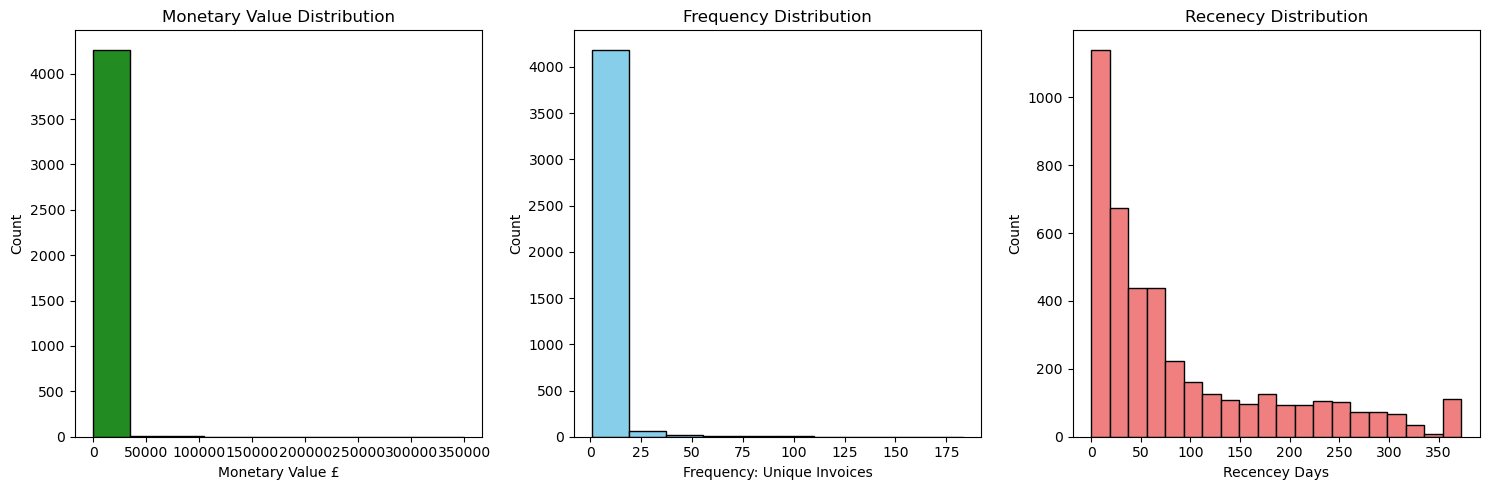

In [18]:
# Plot the data using histograms

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_data['MonetaryValue'], bins=10, color='forestgreen', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value £')
plt.ylabel('Count')


plt.subplot(1, 3, 2)
plt.hist(aggregated_data['Frequency'], bins=10, color='skyblue', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency: Unique Invoices')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_data['Recency'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Recenecy Distribution')
plt.xlabel('Recencey Days')
plt.ylabel('Count')


plt.tight_layout()
plt.show()



As we can see, for Monetary Value and Frequency most of the data sits within one bin, with some outliers in other bins. Recency distribution looks better with a **Poisson Distribution** meaning that there is a discrete probability distribution, 

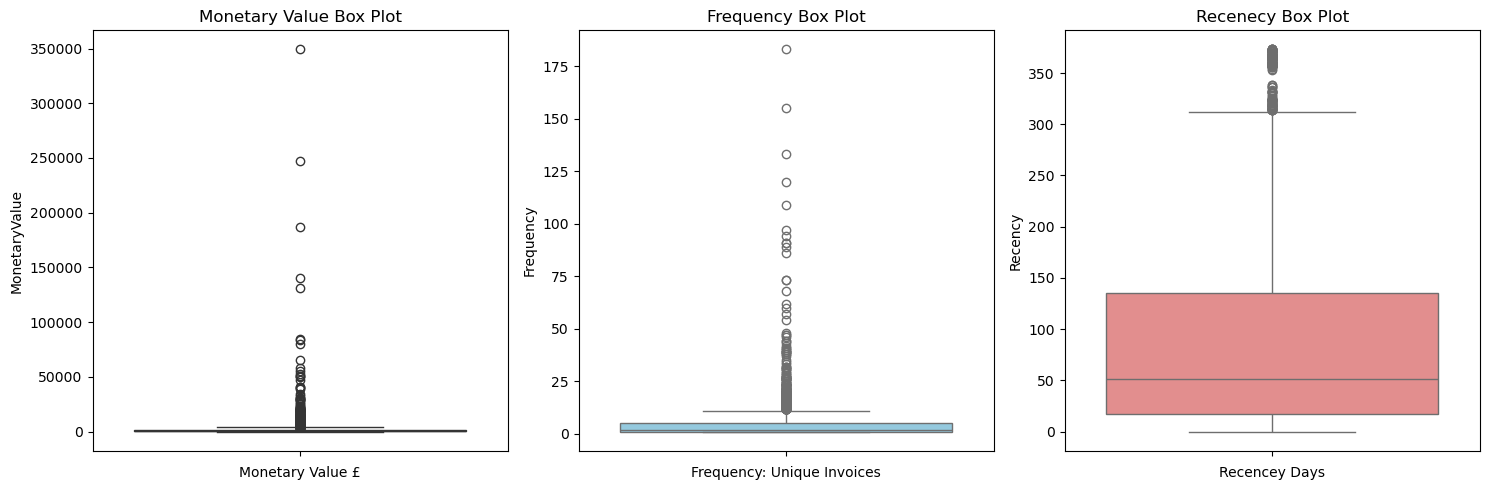

In [19]:

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_data['MonetaryValue'], color='forestgreen')
plt.title('Monetary Value Box Plot')
plt.xlabel('Monetary Value £')


plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_data['Frequency'], color='skyblue')
plt.title('Frequency Box Plot')
plt.xlabel('Frequency: Unique Invoices')

plt.subplot(1, 3, 3)
sns.boxplot(aggregated_data['Recency'], color='lightcoral')
plt.title('Recenecy Box Plot')
plt.xlabel('Recencey Days')


plt.tight_layout()
plt.show()

The box plots show the extent of the outliers for monetary value and frequencey, as you can see the data for both of these is squashed as the outliers are very large. 
<br>
Normally, we would reject the outliers and remove them from the dataset, however this does not apply to our data, because the ouliers represent customers that spent a lot of money, and in more frequent amount so even though they may not be part of the normal distribution data (representing the average customer) these ouliers are important as the client woudl want to focus on these customers as they provide a large revenue. 


So what do we do ? One approach is rather than removing the outliers for our model, we can seperate them from the data and analyse them seperatley.
<br> 
We do this by sperating out any data points that lie outside the IQR. 
<br> 
To extract the data points above the IQR **Third Quarlite  + 1.5 * IQR**
<br>
To extract the data points below the IQR **First Quartile  - 1.5 * IQR**

In [20]:
# Extract data points outliers for Monetary Value

M_IQ1 = aggregated_data["MonetaryValue"].quantile(0.25)
M_IQ3 = aggregated_data['MonetaryValue'].quantile(0.75)
M_IQR = M_IQ3 - M_IQ1

monetary_outliers_data = aggregated_data[(aggregated_data['MonetaryValue'] > (M_IQ3 + 1.5 * M_IQR)) | (aggregated_data['MonetaryValue'] < (M_IQ1 - 1.5 * M_IQR))].copy()

In [21]:
monetary_outliers_data.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceData,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [22]:
# Extract data points outliers for Frequencey

F_IQ1 = aggregated_data['Frequency'].quantile(0.25)
F_IQ3 = aggregated_data['Frequency'].quantile(0.75)
F_IQR = F_IQ3 - F_IQ1

frequency_outliers_data = aggregated_data[(aggregated_data['Frequency'] > (F_IQ3 + 1.5 * F_IQR)) | (aggregated_data['Frequency'] < (F_IQ1 - 1.5 * F_IQR))].copy()

In [23]:
frequency_outliers_data.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceData,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [26]:
# Extract data points outliers for Recency

R_IQ1 = aggregated_data['Recency'].quantile(0.25)
R_IQ3 = aggregated_data['Recency'].quantile(0.75)
R_IQR = R_IQ3 - R_IQ1

recenecy_outliers_data = aggregated_data[(aggregated_data['Recency'] > (R_IQ3 + 1.5 * R_IQR)) | (aggregated_data['Recency'] < (R_IQ1 - 1.5 * R_IQR))].copy()

In [28]:
recenecy_outliers_data.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceData,Recency
count,167.00,167.00,167.00,167,167.00
mean,15429.03,418.32,1.25,2009-12-23 13:52:27.664670720,350.97
min,12439.00,2.95,1.00,2009-12-01 10:49:00,314.00
25%,14115.50,147.35,1.00,2009-12-07 13:03:00,328.50
50%,15413.00,231.90,1.00,2009-12-14 15:07:00,360.00
75%,16812.00,356.18,1.00,2010-01-14 23:56:00,367.00
max,18201.00,9471.50,7.00,2010-01-29 14:22:00,373.00
std,1629.84,950.15,0.80,NaN,20.51


### **Non Out liers Data**

In [35]:
# Monetary Value
# This data excludes the outlisers that are outside the IQR range
nonoutliers_data = aggregated_data[(~aggregated_data.index.isin(monetary_outliers_data.index)) & (~aggregated_data.index.isin(frequency_outliers_data.index))]

In [39]:
nonoutliers_data.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceData,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


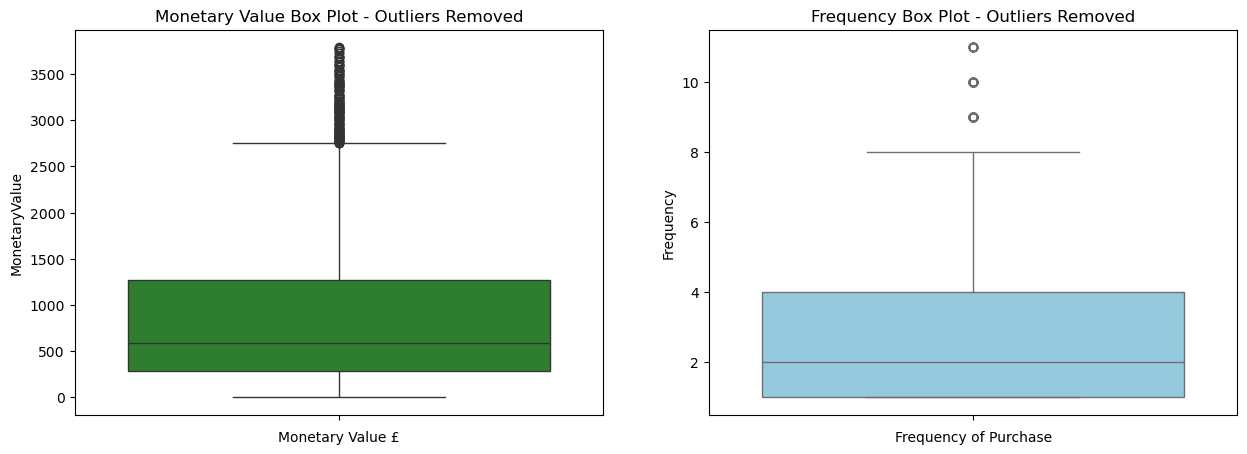

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=nonoutliers_data['MonetaryValue'], color='forestgreen')
plt.title('Monetary Value Box Plot - Outliers Removed')
plt.xlabel('Monetary Value £')

plt.subplot(1, 2, 2)
sns.boxplot(nonoutliers_data['Frequency'], color='skyblue')
plt.title('Frequency Box Plot - Outliers Removed')
plt.xlabel('Frequency of Purchase')

plt.show()

### **3D Scatter Plot of Customer Data**

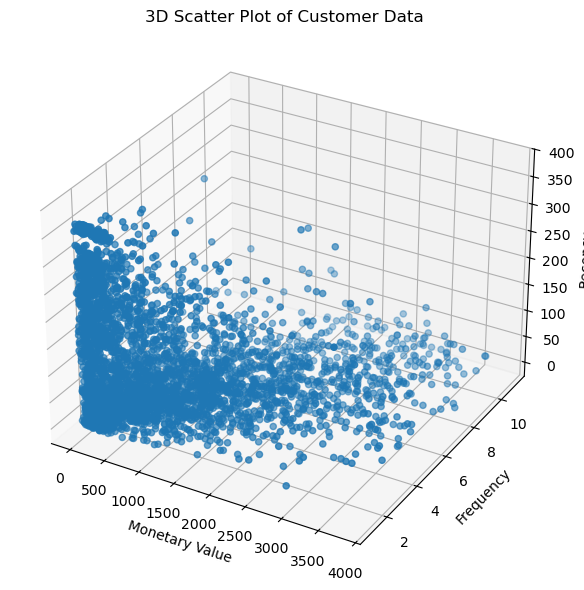

In [43]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(nonoutliers_data['MonetaryValue'], nonoutliers_data['Frequency'], nonoutliers_data['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.tight_layout()
plt.show()

From the scatter plot, we can see that most of the sales generate >0 - £ 1000, with most customers frequently ordering in the 2 - 4 days range. 

Matplot lib scales our data for us, hence the the data is not centered around the monetary value, however for KMeans Clustering (and for most other machine learning models) we need to scale our data before training our model. Unscalled data in this case would produce clusters biased towards Monetary Value as the weight of the values (in 1000s) is from Monetary Value

### **Scaling the Data**

We will be scaling the data using Standardisation. In standardisation, each feature is transformed to have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean from each value and dividing by the standard deviation.

**Standard Scaling**

$$
Z = \frac{x - \mu}{\sigma}
$$

In [53]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(nonoutliers_data[['MonetaryValue', 'Frequency', 'Recency']])
scaled_data = pd.DataFrame(scaled_data, index=nonoutliers_data.index, columns=('MonetaryValue', 'Frequency', 'Recency'))

In [54]:
scaled_data

,MonetaryValue,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


# **KMeans Clustering**


-----

Determine the best k value i.e. number of clusters to form and the silhoutte Score for each clustering

### **Silhoutte Score**

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$


- $s(i)$ is the silhoutte score for a single sample i
- $a(i)$ is the average distance between i and all other points in the same cluster
- $b(i)$ is the minimum average distance between ii adn all points in the nearest cluster to which does **not** belong

The solhoutte score ranges between [-1, 1], a higher value indicates more distinct clusters with less overlap.

A score of 1 means no potential over lap between clusters, whereas a score of -1 means no distinct clusters

In [66]:
max_k = 10

# empty array to hold the intertia values 
intertia = []
# empty array to hold the silhoutte score
silhouette_score_array = []
# range of values to test from 2 to max_k 
k_values = range(2, max_k + 1)

# For each k value, train a model and extract the intertia value 

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data)
    sil_score = silhouette_score(scaled_data, cluster_labels)
    silhouette_score_array.append(sil_score)
    intertia.append(kmeans.inertia_)



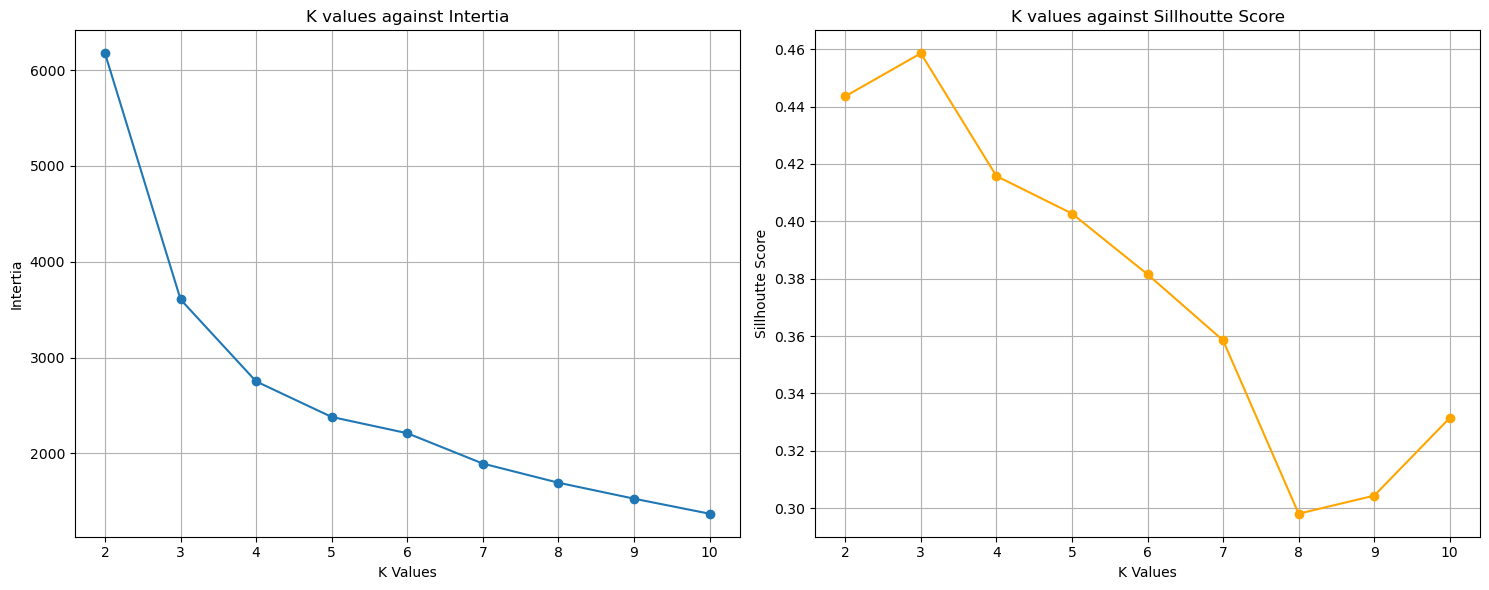

In [67]:
# Plot the k value against the inertia

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, intertia, marker='o')
plt.title('K values against Intertia')
plt.xlabel('K Values')
plt.ylabel('Intertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_score_array, marker='o', color='orange')
plt.title('K values against Sillhoutte Score')
plt.xlabel('K Values')
plt.ylabel('Sillhoutte Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

To determine how many clusters to allocate in our data, we will use the **`Elbow Method`** which picks the point where we see the `elbow` of the graph, i.e most reduction in intertia value, this seems to be at 4-5 clusters. To see decide between 4 or 5 clusters we will use another technique called **`Silhoutte Score`**. The Silhoutte Score for 4 clusters is slightley higher than for 5 clusters, therefore we will form 4 clusters of our data.

In [69]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_data)

In [70]:
nonoutliers_data['Cluster'] = cluster_labels

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_61627/1749909762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonoutliers_data['Cluster'] = cluster_labels


In [71]:
nonoutliers_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceData,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,0
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,2
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,0


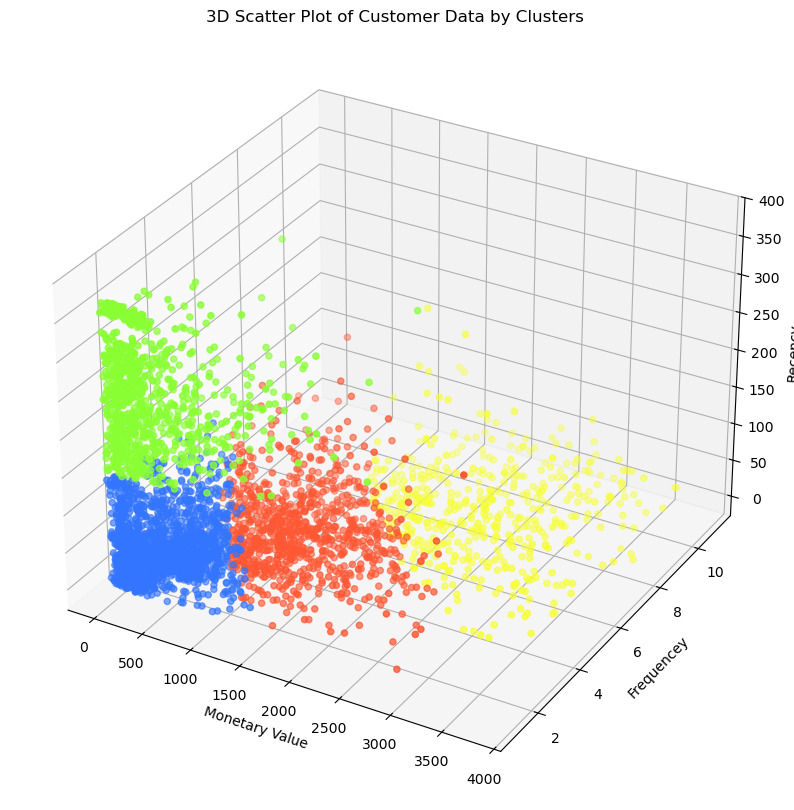

In [73]:
cluster_colours = { 0: "#ff5733", # red
                    1: "#89ff33", # green
                    2: "#3375ff", # blue
                    3: "#f7ff33"  # yellow
                    }

colors = nonoutliers_data['Cluster'].map(cluster_colours)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(nonoutliers_data['MonetaryValue'],
                     nonoutliers_data['Frequency'],
                     nonoutliers_data['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequencey')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data by Clusters')
plt.show()

# Cluster Analysis

### **Violin Plot**

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_61627/2415800179.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=nonoutliers_data['MonetaryValue'], palette='gray', linewidth=1.0)
/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_61627/2415800179.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=nonoutliers_data['Frequency'], palette='gray', linewidth=1.0)
/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_61627/2415800179.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=nonoutliers_data['

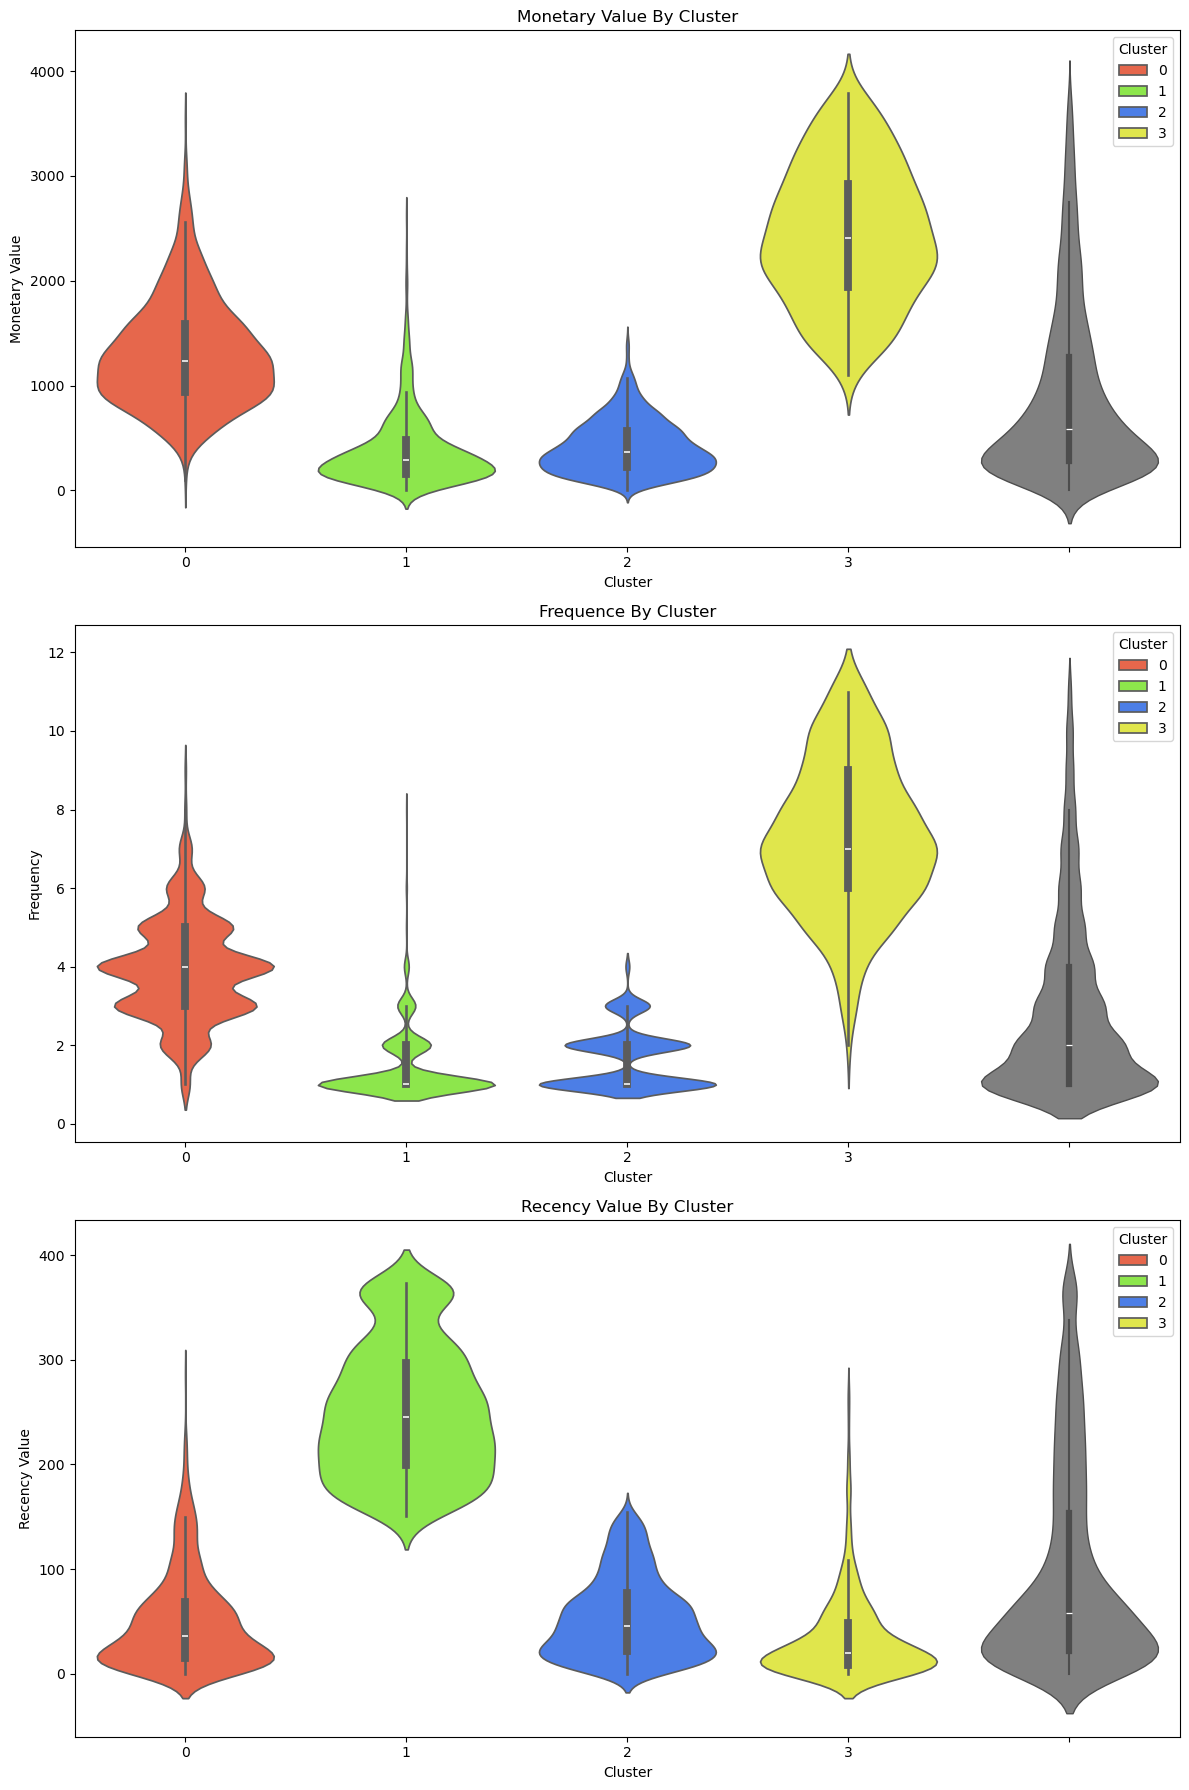

In [75]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=nonoutliers_data['Cluster'], y=nonoutliers_data['MonetaryValue'], palette=cluster_colours, hue=nonoutliers_data['Cluster'])
sns.violinplot(y=nonoutliers_data['MonetaryValue'], palette='gray', linewidth=1.0)
plt.title('Monetary Value By Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=nonoutliers_data['Cluster'], y=nonoutliers_data['Frequency'], palette=cluster_colours, hue=nonoutliers_data['Cluster'])
sns.violinplot(y=nonoutliers_data['Frequency'], palette='gray', linewidth=1.0)
plt.title('Frequence By Cluster')
plt.ylabel('Frequency')



plt.subplot(3, 1, 3)
sns.violinplot(x=nonoutliers_data['Cluster'], y=nonoutliers_data['Recency'], palette=cluster_colours, hue=nonoutliers_data['Cluster'])
sns.violinplot(y=nonoutliers_data['Recency'], palette='gray', linewidth=1.0)
plt.title('Recency Value By Cluster')
plt.ylabel('Recency Value')

plt.tight_layout()
plt.show()




## **Clusters**

1. Cluster 0 (Red): "Retain"

- Rationale: This cluster represents high-value customers who purchase regularly, and made a purchase recently. The focus should be on retention efforts to maintain their loyalty levels. 

2. Cluster 1 (Green): "Re-Engage"

- Rationale: This group includes lower-value, infrequent buyers who havn't purchased recently. The focus should be to re-engage these customers to bring back to the active state.

3. Cluster 2 (Blue): "Nurture"

- Rationale: This cluster represents the least active and lowest-value customers but they have made recent purchases. These customers may be new or need nurturing to increase their engagement and spending. 

4. Cluster 3 (Yellow): "Reward"

- Rationale: These custoemrs have made recent, frequent purchases of high monetary value. These are the loyal customers and therefore should be rewarded. 